In [1]:
import torch
import math
import numpy as np
from network import Network

In [2]:
device = 'cuda'
model = Network(
            input_size = 3,
            hidden_size = 16,
            output_size = 1,
            depth = 8,
            act = torch.nn.Tanh
        ).to(device)

In [3]:
h = 0.1 # 设置空间步长
k = 0.1 # 设置时间步长0.1

x = torch.arange(-1, 1 + h, h) # 在[-1,1]区间上均匀取值，记为x
y = torch.arange(-1, 1 + h, h) # 在[-1,1]区间上均匀取值，记为y
t = torch.arange(0, 1 + k, k) # 在[0,1]区间均匀取值，记为t

# 将t和x组合， 形成时间空间网格，记录在张量X_inside中
X_inside = torch.stack(torch.meshgrid(x, y, t)).reshape(3, -1).T

u_inside = torch.ones(X_inside.size()[0], 2)

D:\annaconda\envs\pytorch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
k = 0.1 # 设置时间步长0.1
t = torch.arange(0, 1 + k, k) 
t

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [18]:
# 边界处的时空坐标
bcx1 = torch.stack(torch.meshgrid(x[0], y, t)).reshape(3, -1).T
bcx2 = torch.stack(torch.meshgrid(x[-1], y,  t)).reshape(3, -1).T
bcy1 = torch.stack(torch.meshgrid(x, y[0], t)).reshape(3, -1).T
bcy2 = torch.stack(torch.meshgrid(x, y[-1],  t)).reshape(3, -1).T
ic = torch.stack(torch.meshgrid(x, y, t[0])).reshape(3, -1).T
X_boundary = torch.cat([bcx1 ,bcx2, bcy1, bcy2, ic])

In [19]:
X_boundary

tensor([[-1.0000, -1.0000,  0.0000],
        [-1.0000, -1.0000,  0.0100],
        [-1.0000, -1.0000,  0.0200],
        ...,
        [ 1.0000,  0.9800,  0.0000],
        [ 1.0000,  0.9900,  0.0000],
        [ 1.0000,  1.0000,  0.0000]])

In [6]:
# 边界处的u值
# 初边值条件 u(-1,y,t)=0, u(1,y,t)=0, u(x,y,0)=-sin(pi*x)-sin(pi*y)
# !!!需要针对具体方程重写
T_bcx1 = torch.zeros(len(bcx1)) # x=-1处的第一类边界条件 u=0
T_bcx2 = torch.zeros(len(bcx2)) # x=1 处的第二类边界条件 u=0
T_bcy1 = torch.zeros(len(bcy1))  # y=-1处的第一类边界条件 u=0
T_bcy2 = torch.zeros(len(bcy2))  # y=1 处的第二类边界条件 u=0
T_ic = -torch.sin(math.pi * ic[:, 0]) -torch.sin(math.pi * ic[:, 1])
T_boundary = torch.cat([T_bcx1 ,T_bcx2, T_bcy1, T_bcy2, T_ic])# 将所有边界处的T值整合为一个张量
T_boundary = T_boundary.unsqueeze(1)

In [7]:
# 将数据放入GPU
X_inside = X_inside.to(device)
X_boundary = X_boundary.to(device)
T_boundary = T_boundary.to(device)
u_inside = u_inside.to(device)
X_inside.requires_grad = True # 设置：需要计算对X的梯度

# 设置MSE
MSE = torch.nn.MSELoss()



In [8]:
X_inside

tensor([[-1.0000, -1.0000,  0.0000],
        [-1.0000, -1.0000,  0.1000],
        [-1.0000, -1.0000,  0.2000],
        ...,
        [ 1.0000,  1.0000,  0.8000],
        [ 1.0000,  1.0000,  0.9000],
        [ 1.0000,  1.0000,  1.0000]], device='cuda:0', requires_grad=True)

In [93]:

T_inside = model(X_inside)

dT_dxyt = torch.autograd.grad(
            inputs = X_inside,
            outputs = T_inside,
            grad_outputs = torch.ones_like(T_inside),
            retain_graph = True,
            create_graph = True
        )[0]

dT_dX = torch.autograd.grad(
            inputs = X_inside,
            outputs = T_inside,
            grad_outputs = torch.ones_like(T_inside),
            retain_graph = True,
            create_graph = True
        )[0]

# 使用自动微分求U对X的二阶导数

dT_dxx = torch.autograd.grad(
    inputs=X_inside,
    outputs=dT_dX,
    grad_outputs=torch.ones_like(dT_dX),
    retain_graph=True,
    create_graph=True
)[0][:, 0]

dT_dyy = torch.autograd.grad(
    inputs=X_inside,
    outputs=dT_dX,
    grad_outputs=torch.ones_like(dT_dX),
    retain_graph=True,
    create_graph=True
)[0][:,1]

In [115]:
u_inside * dT_dxyt[:,:2]

tensor([[-0.0006,  0.0010],
        [-0.0006,  0.0008],
        [-0.0005,  0.0006],
        ...,
        [-0.0005,  0.0008],
        [-0.0005,  0.0010],
        [-0.0005,  0.0010]], device='cuda:0', grad_fn=<MulBackward0>)

In [117]:
dT_dX[:,:2]

tensor([[-0.0006,  0.0010],
        [-0.0006,  0.0008],
        [-0.0005,  0.0006],
        ...,
        [-0.0005,  0.0008],
        [-0.0005,  0.0010],
        [-0.0005,  0.0010]], device='cuda:0', grad_fn=<SliceBackward0>)

In [96]:
dT_dxx

tensor([-5.3257e-05,  3.2104e-05,  1.7002e-04,  ...,  1.0672e-04,
         1.4199e-04,  1.2369e-04], device='cuda:0', grad_fn=<SelectBackward0>)

In [97]:
grad_outputs=torch.ones_like(dT_dX)
grad_outputs

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [79]:
x_test = torch.tensor([1.,1.,1.])
x_test.requires_grad = True
y = x_test**2 + sum(x_test)**2

In [80]:
dy_dx = torch.autograd.grad(inputs=x_test, outputs=y, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)
dy_dx

(tensor([20., 20., 20.], grad_fn=<AddBackward0>),)

In [81]:
dy_dxx = torch.autograd.grad(inputs=x_test, outputs=dy_dx, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)
dy_dxx

(tensor([20., 20., 20.], grad_fn=<AddBackward0>),)

In [ ]:
T_inside

In [32]:
#　验证预测

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 选择GPU或CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 从文件加载已经训练完成的模型
model_loaded_pro = torch.load('model_pro.pth', map_location=device)
model_loaded_retro = torch.load('model_retro11.pth', map_location=device)
model_loaded_pro.eval()  # 设置模型为evaluation状态
model_loaded_retro.eval()

# 生成时空网格
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
y = torch.arange(-1, 1, h)
t_pro = torch.arange(0, 1, k)
t_retro = torch.arange(0, 1, k)
X_pro = torch.stack(torch.meshgrid(x, y, t_pro)).reshape(3, -1).T
X_pro = X_pro.to(device)
X_retro = torch.stack(torch.meshgrid(x, y, t_retro)).reshape(3, -1).T
X_retro = X_retro.to(device)

# 计算该时空网格对应的预测值
with torch.no_grad():
    T_pred_pro = model_loaded_pro(X_pro).reshape(len(x), len(y), len(t_pro)).cpu().numpy()
    T_pred_retro = model_loaded_retro(X_retro).reshape(len(x), len(y), len(t_retro)).cpu().numpy()


In [33]:
T_pred_retro.shape[2]

100

<IPython.core.display.Javascript object>


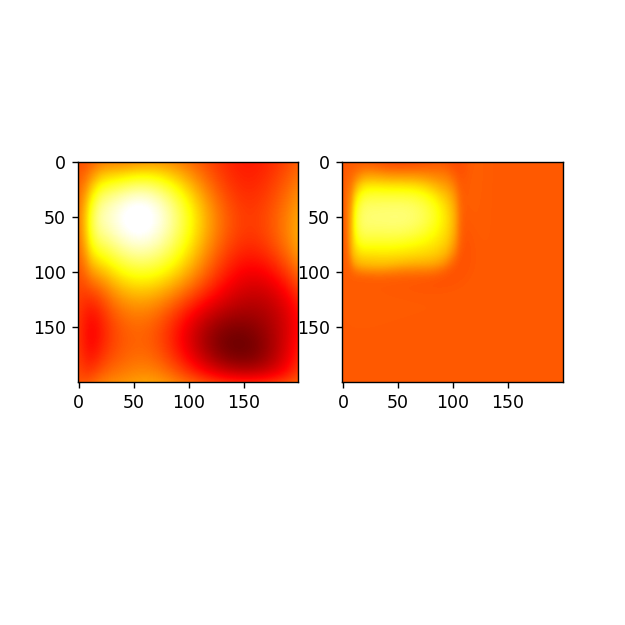

In [38]:
# 滑动条控制
# 绘制计算结果
from matplotlib.widgets import Slider, Button, RadioButtons
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig,ax = plt.subplots(1,2,figsize=(5,5))
plt.subplots_adjust(bottom=.25)

p0 = ax[0].imshow(T_pred_pro[:,:,0], cmap='hot', vmin=-2, vmax=2)
p1 = ax[1].imshow(T_pred_retro[:,:,0], cmap='hot', vmin=-2, vmax=2)
# plt.colorbar(p0)
# plt.colorbar(p1)

# ax_slide=plt.axes([.25,.1,.65,.03])
# s_factor=Slider(ax_slide,"Time",valmin=0,valmax=199,valinit=0,valstep=1)

def update(time):
    current_time = s_factor.val
    p0.set_data(T_pred_pro[:,:,time])
    p1.set_data(T_pred_retro[:,:,time])
#     fig.canvas.draw()
    return p0,p1
    

# s_factor.on_changed(update)
plt.show()
ani = FuncAnimation(fig, update, frames=range(T_pred_retro.shape[2]), interval=100)
ani.save('paralell2.gif', writer='pillow', fps=10)

<IPython.core.display.Javascript object>


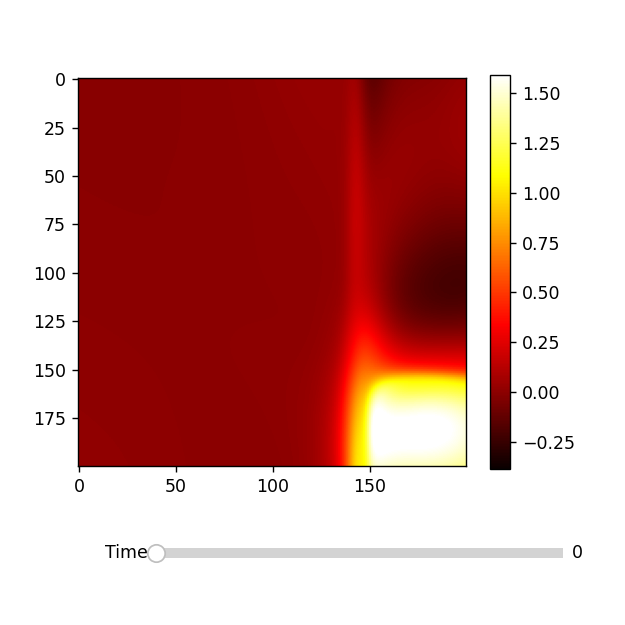

In [25]:
# 滑动条控制
# 绘制计算结果
from matplotlib.widgets import Slider, Button, RadioButtons

%matplotlib notebook

fig = plt.figure(figsize=(5,5))
plt.subplots_adjust(bottom=.25)
ax = fig.subplots(1,1)

p = ax.imshow(T_pred_retro[:,:,0], cmap='hot')

plt.colorbar(p)

ax_slide=plt.axes([.25,.1,.65,.03])
s_factor=Slider(ax_slide,"Time",valmin=0,valmax=199,valinit=0,valstep=1)

def update(time):
    current_time = s_factor.val
    p.set_data(T_pred_retro[:,:,time])
    fig.canvas.draw()
ani = FuncAnimation(fig, update, frames=range(T_pred_retro.shape[2]), interval=100)
s_factor.on_changed(update)
plt.show()

<IPython.core.display.Javascript object>


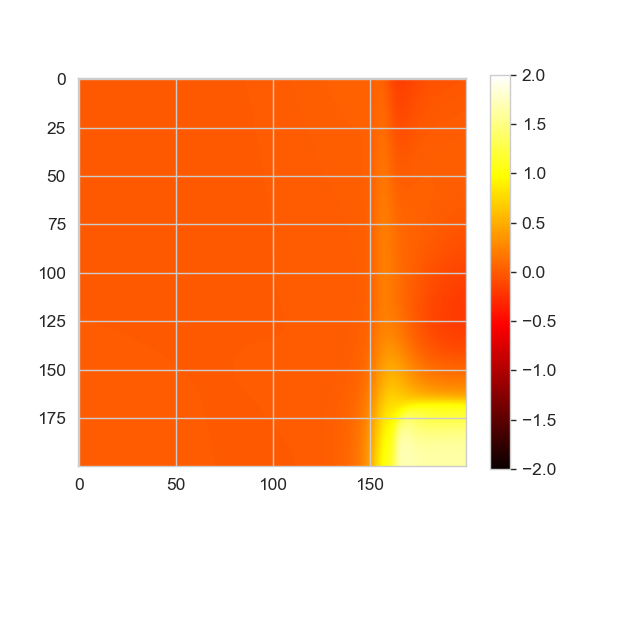

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider
from matplotlib import animation

%matplotlib notebook

# 初始化时间
time = 0

# 创建图形和轴
fig = plt.figure(figsize=(5, 5))
plt.subplots_adjust(bottom=0.25)
ax = fig.subplots(1, 1)

# 显示初始热图
p = ax.imshow(T_pred_retro[:, :, time], cmap='hot', vmin=-2, vmax=2)

# 添加颜色条
plt.colorbar(p)


# 更新函数，用于更新动画中的图像
def update(i):
    p.set_data(T_pred_retro[:, :, i])
    return p

# 创建动画，更新间隔为 100 毫秒
ani = FuncAnimation(fig, update, frames=range(T_pred_retro.shape[2]), interval=100)

# 显示图形
plt.show()

# 保存动画为 GIF 文件
ani.save('toy200_retro.gif', writer='pillow', fps=10)  # FPS 改为 10，适合 GIF 动画


In [9]:

# 生成时空网格
h = 0.1
k = 0.1
x = torch.arange(-1, 1 + h, h)
y = torch.arange(-1, 1 + h, h)
t = torch.arange(0, 1 + k, k)
X = torch.stack(torch.meshgrid(x, y, t)).reshape(3, -1).T
X = X.to(device)

# 计算该时空网格对应的预测值
with torch.no_grad():
    T_pred = model_loaded_pro(X).reshape(len(x), len(y), len(t)).cpu().numpy()



In [11]:
np.shape(T_pred)

(21, 21, 11)

In [16]:
T_pred11 = T_pred[:,:,-1]

np.savetxt('T_pred11.txt', T_pred11)

# print("T_pred99 has been saved to T_pred.txt")

In [17]:
np.shape(T_pred11)

(21, 21)

In [18]:
np.shape(torch.from_numpy(T_pred11.reshape(-1,1)).squeeze())

torch.Size([441])

<IPython.core.display.Javascript object>


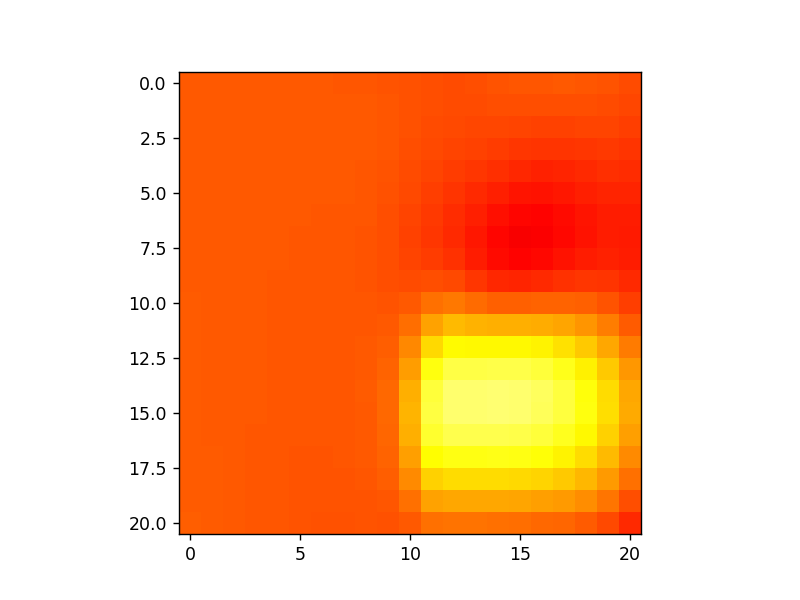

In [31]:
T_ic = np.loadtxt('T_pred11.txt')
fig = plt.figure()
plt.imshow(T_ic, cmap='hot', vmin=-2, vmax=2)
plt.show()

In [114]:
T_ic = -torch.sin(math.pi * ic[:, 0]) -torch.sin(math.pi * ic[:, 1])#
np.shape(T_ic.reshape(-1, 1))

torch.Size([441, 1])

<IPython.core.display.Javascript object>


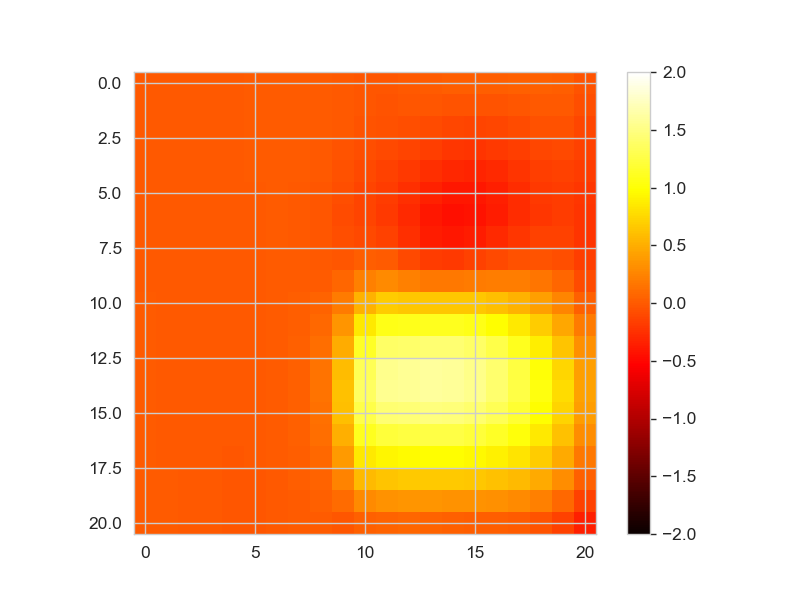

In [179]:

fig = plt.figure()
ax = fig.subplots(1,1)
pp = ax.imshow(T_ic, cmap='hot', vmin=-2, vmax=2)
plt.colorbar(pp)
plt.show()

In [12]:
import torch

# 检查CUDA是否可用
if torch.cuda.is_available():
    print(f"CUDA is available. Detected {torch.cuda.device_count()} GPU(s).")
else:
    print("CUDA is not available.")

CUDA is available. Detected 1 GPU(s).


In [15]:
h = 0.01  # 设置空间步长
k = 0.01  # 设置时间步长
x = torch.arange(-1, 1 + h, h)  # 在[-1,1]区间上均匀取值，记为x
y = torch.arange(-1, 1 + h, h)  # 在[-1,1]区间上均匀取值，记为y
t = torch.arange(0, 1 + k, k)  # 在[0,1]区间均匀取值，记为t

# 边界处的时空坐标
bcx1 = torch.stack(torch.meshgrid(x[0], y, t)).reshape(3, -1).T
bcx2 = torch.stack(torch.meshgrid(x[-1], y, t)).reshape(3, -1).T
bcy1 = torch.stack(torch.meshgrid(x, y[0], t)).reshape(3, -1).T
bcy2 = torch.stack(torch.meshgrid(x, y[-1], t)).reshape(3, -1).T
ic = torch.stack(torch.meshgrid(x, y, t[0])).reshape(3, -1).T
X_boundary = torch.cat([bcx1, bcx2, bcy1, bcy2, ic])

# 边界处的T值
# 初边值条件 T(-1,y,t)=0, T(1,y,t)=0, T(x,y,1)=-sin(pi*x)-sin(pi*y)
# !!!需要针对具体方程重写
T_bcx1 = torch.zeros(len(bcx1))  # x=-1处的第一类边界条件 T=0
T_bcx2 = torch.zeros(len(bcx2))  # x=1 处的第二类边界条件 T=0
T_bcy1 = torch.zeros(len(bcy1))  # y=-1处的第一类边界条件 T=0
T_bcy2 = torch.zeros(len(bcy2))  # y=1 处的第二类边界条件 T=0
T_ic = -torch.sin(math.pi * ic[:, 0]) - torch.sin(math.pi * ic[:, 1])  # t=0的初值条件 T=-sin(pi*x)-sin(pi*y)
T_boundary = torch.cat([T_bcx1, T_bcx2, T_bcy1, T_bcy2, T_ic])  # 将所有边界处的T值整合为一个张量
T_boundary = T_boundary.unsqueeze(1)

In [16]:
X_boundary

tensor([[-1.0000, -1.0000,  0.0000],
        [-1.0000, -1.0000,  0.0100],
        [-1.0000, -1.0000,  0.0200],
        ...,
        [ 1.0000,  0.9800,  0.0000],
        [ 1.0000,  0.9900,  0.0000],
        [ 1.0000,  1.0000,  0.0000]])